In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

In [2]:
#path for RFID file
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Manuscripts/2022_RFIDVDM/repo/Idspyder-21.12.13.csv'

#check where event duration data starts
data_RFID_int = pd.read_csv(RFID_path, sep=';', encoding='utf-16')
data_RFID_int = pd.DataFrame(data = data_RFID_int)

data_RFID_int.head(40)

,DateTime,IdRFID,IdLabel,unitLabel,eventDuration,sense1duration,sense1Events,senseRFIDrecords,outFuncLabel,outLabel,SystemMsg,MsgValue1,MsgValue2,MsgValue3
0,#ID-Device,Spyder1.1,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#ID-Device,Spyder1.2,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#ID-Device,Spyder1.3,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#ID-Device,Spyder1.4,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#ID-Device,Spyder1.5,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,#ID-Device,Spyder1.6,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,#ID-Device,Spyder1.7,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,#ID-Device,Spyder1.8,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,#ID-Device,Spyder1.9,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,#ID-Device,Spyder1.10,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Get file and update datetime

In [3]:
row_drop = 33 #row event duration data starts

data_RFID = pd.read_csv(RFID_path, sep=';', encoding='utf-16')
data_RFID = pd.DataFrame(data = data_RFID)
data_RFID = data_RFID.iloc[row_drop: , :]
print(data_RFID.shape)
    
#drop rows with no event duration
data_RFID = data_RFID[~data_RFID['eventDuration'].isna()]
    
#add file name - will use with meta data file
data_RFID['RFID_file'] = RFID_path.split('/')[-1]
    
#convert from ms to sec
data_RFID['eventDuration'] = data_RFID['eventDuration']/1000
#clean up and create datetime columns
data_RFID['start_datetime'] = pd.to_datetime(data_RFID['DateTime'], unit='d')
data_RFID['RFID_datetime_start'] = [x.replace(year = 2021) - dt.timedelta(days = 2) for x in data_RFID['start_datetime']] 
data_RFID['RFID_date'] = data_RFID['RFID_datetime_start'].dt.date 
data_RFID['RFID_day'] = data_RFID['RFID_datetime_start'].dt.day 
data_RFID['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
data_RFID['RFID_hour'] = data_RFID['RFID_datetime_start'].dt.hour
data_RFID['RFID_min'] = data_RFID['RFID_datetime_start'].dt.minute
data_RFID['RFID_second'] = data_RFID['RFID_datetime_start'].dt.second

#clean columns
data_RFID = data_RFID[['RFID_file', 'IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]

print(data_RFID.shape,'\n')

data_RFID.head()

(206859, 14)
(206858, 11) 



,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
33,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40
34,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49
35,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51
36,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2
37,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53


In [4]:
#examine data points per day
data_RFID['RFID_day'].value_counts()

14    51712
15    28742
18    25859
17    25247
19    23920
16    23635
13    20208
20    7535 
Name: RFID_day, dtype: int64

In [5]:
#examine data points per animal
data_RFID['IdRFID'].value_counts()

041AC00422    24335
041AC006F3    15387
041AC02849    15261
041AC033A1    14783
041AC028F2    14756
041ABFF7C1    14589
041AC03717    13397
041AC00EFA    12689
041ABFE8D4    11928
041AC038C9    11914
041AC00F03    9788 
041AC00A9F    9412 
041AC02E92    8308 
041AC009ED    8210 
041ABFEC1B    7485 
041ABFF18E    6025 
041AC03A4B    4941 
041ABFF5CF    3650 
Name: IdRFID, dtype: int64

#### Compute endtime 

In [6]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(206858, 13)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
33,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40,2021-12-13 16:16:42.685004800,16:16:42
34,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49,2021-12-13 16:16:49.465019200,16:16:49
35,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51,2021-12-13 16:16:52.153003200,16:16:52
36,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2,2021-12-13 16:17:03.074011200,16:17:03
37,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53,2021-12-13 16:17:04.440964800,16:17:04


#### Add day, hour, and min counts

In [7]:
#column of running day count
dat_map = dict(zip(data_RFID['RFID_date'].unique(), np.arange(1,len(data_RFID['RFID_date'].unique())+1)))
data_RFID['RFID_day_count'] = data_RFID['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID['RFID_min_count'] = (data_RFID['RFID_hour']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count'] = (data_RFID['RFID_min_count']*60) + data_RFID['RFID_second'] 

#column of running hour and minute count across all days
data_RFID['RFID_hour_count_running'] = (data_RFID['RFID_day_count']*24) + data_RFID['RFID_hour'] - 24
data_RFID['RFID_min_count_running'] = (data_RFID['RFID_hour_count_running']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count_running'] = (data_RFID['RFID_min_count_running']*60) + data_RFID['RFID_second'] - 60

print(data_RFID.shape)
data_RFID.head()

(206858, 19)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
33,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40,2021-12-13 16:16:42.685004800,16:16:42,1,976,58600,16,976,58540
34,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49,2021-12-13 16:16:49.465019200,16:16:49,1,976,58609,16,976,58549
35,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51,2021-12-13 16:16:52.153003200,16:16:52,1,976,58611,16,976,58551
36,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2,2021-12-13 16:17:03.074011200,16:17:03,1,977,58622,16,977,58562
37,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53,2021-12-13 16:17:04.440964800,16:17:04,1,976,58613,16,976,58553


In [8]:
#examine mapping of date to day count
dat_map

{datetime.date(2021, 12, 13): 1,
 datetime.date(2021, 12, 14): 2,
 datetime.date(2021, 12, 15): 3,
 datetime.date(2021, 12, 16): 4,
 datetime.date(2021, 12, 17): 5,
 datetime.date(2021, 12, 18): 6,
 datetime.date(2021, 12, 19): 7,
 datetime.date(2021, 12, 20): 8}

In [9]:
#examine data points per animal per RFID sensor 
data_RFID.groupby(['unitLabel'])['IdRFID'].value_counts()

unitLabel   IdRFID    
Spyder1.10  041AC03717    2385
            041AC00A9F    1639
            041ABFE8D4    1529
Spyder1.11  041AC03717    3745
            041ABFE8D4    2807
            041AC00A9F    2703
Spyder1.12  041ABFE8D4    5495
            041AC03717    4304
            041AC00A9F    3613
Spyder1.5   041AC02E92    2817
            041ABFF18E    1817
            041ABFF5CF    823 
Spyder1.6   041AC02E92    2929
            041ABFF18E    1244
            041ABFF5CF    867 
Spyder1.8   041ABFF18E    2964
            041AC02E92    2562
            041ABFF5CF    1960
Spyder1.9   041AC03717    2963
            041ABFE8D4    2097
            041AC00A9F    1457
Spyder2.17  041AC00422    7680
            041ABFF7C1    4725
            041AC00EFA    3435
Spyder2.18  041AC00422    5672
            041AC00EFA    4614
            041ABFF7C1    4013
Spyder2.19  041AC00422    4427
            041ABFF7C1    2115
            041AC00EFA    1728
Spyder2.20  041AC00422    6556
            041A

#### Add light dark

In [10]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID['ld_seg'] = data_RFID['RFID_hour'].apply(assign_ld)

print(data_RFID.shape)
data_RFID.head()


(206858, 20)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
33,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40,2021-12-13 16:16:42.685004800,16:16:42,1,976,58600,16,976,58540,light
34,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49,2021-12-13 16:16:49.465019200,16:16:49,1,976,58609,16,976,58549,light
35,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51,2021-12-13 16:16:52.153003200,16:16:52,1,976,58611,16,976,58551,light
36,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2,2021-12-13 16:17:03.074011200,16:17:03,1,977,58622,16,977,58562,light
37,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53,2021-12-13 16:17:04.440964800,16:17:04,1,976,58613,16,976,58553,light


#### Add day/night mapping (lines up dates and ld segments)

In [11]:
ld_mapping_path = '/Users/abbieschindler/Documents/Schindler_Lab/Manuscripts/2022_RFIDVDM/repo/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(57, 4)


,day,ld_seg,ld_cycle,ld_day
0,1,light,light,1
1,1,dark_pm,dark,1
2,2,dark_am,dark,1
3,2,light,light,2
4,2,dark_pm,dark,2


In [12]:
data_RFID = data_RFID.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID.shape)
data_RFID.head()

(206858, 23)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day
0,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40,2021-12-13 16:16:42.685004800,16:16:42,1,976,58600,16,976,58540,light,1,light,1
1,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49,2021-12-13 16:16:49.465019200,16:16:49,1,976,58609,16,976,58549,light,1,light,1
2,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51,2021-12-13 16:16:52.153003200,16:16:52,1,976,58611,16,976,58551,light,1,light,1
3,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2,2021-12-13 16:17:03.074011200,16:17:03,1,977,58622,16,977,58562,light,1,light,1
4,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53,2021-12-13 16:17:04.440964800,16:17:04,1,976,58613,16,976,58553,light,1,light,1


#### Map unitLabel and bottle contents

In [13]:
#note you will need to update this file with your RFID naming scheme (i.e., unitLabel) and associated substances (i.e., RFID/substance pairs for each drinking station)
RFID_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Manuscripts/2022_RFIDVDM/repo/RFID_substance_mapping.xlsx'

RFID_bottle_assignment = pd.read_excel(RFID_bottle_assignment_path)
RFID_bottle_assignment = pd.DataFrame(data = RFID_bottle_assignment)
print(RFID_bottle_assignment.shape)
RFID_bottle_assignment.head()

(1, 35)


,cohort,RFID_file,VDM_file,Spyder1.1,Spyder1.2,Spyder1.3,Spyder1.4,Spyder1.5,Spyder1.6,Spyder1.7,Spyder1.8,Spyder1.9,Spyder1.10,Spyder1.11,Spyder1.12,Spyder1.13,Spyder1.14,Spyder1.15,Spyder1.16,Spyder2.17,Spyder2.18,Spyder2.19,Spyder2.20,Spyder2.21,Spyder2.22,Spyder2.23,Spyder2.24,Spyder2.25,Spyder2.26,Spyder2.27,Spyder2.28,Spyder2.29,Spyder2.30,Spyder2.31,Spyder2.32
0,flavor,Idspyder-21.12.13.csv,c.br.o.g_fm_211213.csv,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape,cherry,blue_ras,orange,grape


In [14]:
file=data_RFID['RFID_file'].unique()[0]

#update 'Spyder1.1':'Spyder2.32' with your unitLabel name span
RFID_bottle_map = RFID_bottle_assignment[RFID_bottle_assignment['RFID_file']==file].reset_index().loc[0,'Spyder1.1':'Spyder2.32'].to_dict()

data_RFID['unitLabel_drink'] = data_RFID['unitLabel'].map(RFID_bottle_map)
print(data_RFID.shape) #if map was sucsessful should have the same number of rows as previous 

data_RFID.head()

(206858, 24)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,unitLabel_drink
0,Idspyder-21.12.13.csv,041ABFF18E,Spyder1.8,2.176,2021-12-13 16:16:40.509004800,2021-12-13,13,16:16:40,16,16,40,2021-12-13 16:16:42.685004800,16:16:42,1,976,58600,16,976,58540,light,1,light,1,grape
1,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.001,2021-12-13 16:16:49.464019200,2021-12-13,13,16:16:49,16,16,49,2021-12-13 16:16:49.465019200,16:16:49,1,976,58609,16,976,58549,light,1,light,1,orange
2,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,0.459,2021-12-13 16:16:51.694003200,2021-12-13,13,16:16:51,16,16,51,2021-12-13 16:16:52.153003200,16:16:52,1,976,58611,16,976,58551,light,1,light,1,orange
3,Idspyder-21.12.13.csv,041AC038C9,Spyder2.26,0.075,2021-12-13 16:17:02.999011200,2021-12-13,13,16:17:02,16,17,2,2021-12-13 16:17:03.074011200,16:17:03,1,977,58622,16,977,58562,light,1,light,1,blue_ras
4,Idspyder-21.12.13.csv,041AC038C9,Spyder2.27,11.175,2021-12-13 16:16:53.265964800,2021-12-13,13,16:16:53,16,16,53,2021-12-13 16:17:04.440964800,16:17:04,1,976,58613,16,976,58553,light,1,light,1,orange


In [15]:
data_RFID.groupby('unitLabel_drink')['unitLabel'].value_counts()

unitLabel_drink  unitLabel 
blue_ras         Spyder2.18    14299
                 Spyder2.22    7242 
                 Spyder1.10    5553 
                 Spyder1.6     5040 
                 Spyder2.30    4656 
                 Spyder2.26    4594 
cherry           Spyder2.21    21982
                 Spyder2.17    15840
                 Spyder2.25    6766 
                 Spyder1.9     6517 
                 Spyder2.29    5551 
                 Spyder1.5     5457 
grape            Spyder2.28    14848
                 Spyder1.12    13412
                 Spyder2.20    13204
                 Spyder2.24    10460
                 Spyder1.8     7486 
                 Spyder2.32    3969 
orange           Spyder2.27    10755
                 Spyder1.11    9255 
                 Spyder2.19    8270 
                 Spyder2.31    6460 
                 Spyder2.23    5242 
Name: unitLabel, dtype: int64

#### Add metadata and clean

In [16]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Manuscripts/2022_RFIDVDM/repo/meta_data.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape) #if merge was sucsessful should have the same number of rows as previous
data_RFID_final.head()

(206858, 33)


,Round,Startdate,SIP_Cage,IdRFID,Animal,ARF_Cage,Sex,weight_pre,notes,index,RFID_file,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,unitLabel_drink
0,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,8,Idspyder-21.12.13.csv,Spyder1.8,0.076,2021-12-13 16:17:54.701030400,2021-12-13,13,16:17:54,16,17,54,2021-12-13 16:17:54.777030400,16:17:54,1,977,58674,16,977,58614,light,1,light,1,grape
1,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,10,Idspyder-21.12.13.csv,Spyder1.8,0.314,2021-12-13 16:17:57.356016000,2021-12-13,13,16:17:57,16,17,57,2021-12-13 16:17:57.670016000,16:17:57,1,977,58677,16,977,58617,light,1,light,1,grape
2,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,20,Idspyder-21.12.13.csv,Spyder1.5,0.558,2021-12-13 16:18:58.951958400,2021-12-13,13,16:18:58,16,18,58,2021-12-13 16:18:59.509958400,16:18:59,1,978,58738,16,978,58678,light,1,light,1,cherry
3,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,21,Idspyder-21.12.13.csv,Spyder1.5,0.073,2021-12-13 16:19:00.823987200,2021-12-13,13,16:19:00,16,19,0,2021-12-13 16:19:00.896987200,16:19:00,1,979,58740,16,979,58680,light,1,light,1,cherry
4,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,22,Idspyder-21.12.13.csv,Spyder1.5,0.075,2021-12-13 16:19:03.210960000,2021-12-13,13,16:19:03,16,19,3,2021-12-13 16:19:03.285960000,16:19:03,1,979,58743,16,979,58683,light,1,light,1,cherry


In [17]:
data_RFID_final = data_RFID_final[['Round', 'Startdate', 'SIP_Cage', 'IdRFID', 'Animal', 'ARF_Cage', 'Sex', 
                                   'unitLabel_drink', 'unitLabel', 'eventDuration',
                                   'ld_cycle', 'ld_day', 'day', 'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_datetime_start', 'RFID_datetime_end', 'RFID_time_start', 'RFID_time_end', 
                                   'RFID_min_count', 'RFID_sec_count', 
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running', 
                                   'RFID_file', 'weight_pre', 'notes']]

print(data_RFID_final.shape)
data_RFID_final.head()

(206858, 28)


,Round,Startdate,SIP_Cage,IdRFID,Animal,ARF_Cage,Sex,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,notes
0,flavor,21.12.13,2,041ABFF5CF,1616,467,male,grape,Spyder1.8,0.076,light,1,1,16,17,54,2021-12-13 16:17:54.701030400,2021-12-13 16:17:54.777030400,16:17:54,16:17:54,977,58674,16,977,58614,Idspyder-21.12.13.csv,29.5,NaN
1,flavor,21.12.13,2,041ABFF5CF,1616,467,male,grape,Spyder1.8,0.314,light,1,1,16,17,57,2021-12-13 16:17:57.356016000,2021-12-13 16:17:57.670016000,16:17:57,16:17:57,977,58677,16,977,58617,Idspyder-21.12.13.csv,29.5,NaN
2,flavor,21.12.13,2,041ABFF5CF,1616,467,male,cherry,Spyder1.5,0.558,light,1,1,16,18,58,2021-12-13 16:18:58.951958400,2021-12-13 16:18:59.509958400,16:18:58,16:18:59,978,58738,16,978,58678,Idspyder-21.12.13.csv,29.5,NaN
3,flavor,21.12.13,2,041ABFF5CF,1616,467,male,cherry,Spyder1.5,0.073,light,1,1,16,19,0,2021-12-13 16:19:00.823987200,2021-12-13 16:19:00.896987200,16:19:00,16:19:00,979,58740,16,979,58680,Idspyder-21.12.13.csv,29.5,NaN
4,flavor,21.12.13,2,041ABFF5CF,1616,467,male,cherry,Spyder1.5,0.075,light,1,1,16,19,3,2021-12-13 16:19:03.210960000,2021-12-13 16:19:03.285960000,16:19:03,16:19:03,979,58743,16,979,58683,Idspyder-21.12.13.csv,29.5,NaN


In [18]:
data_RFID_final.groupby('Sex')['SIP_Cage'].value_counts()

Sex     SIP_Cage
female  5           51613
        6           44926
        3           34737
male    7           36963
        8           20636
        2           17983
Name: SIP_Cage, dtype: int64

#### Viz

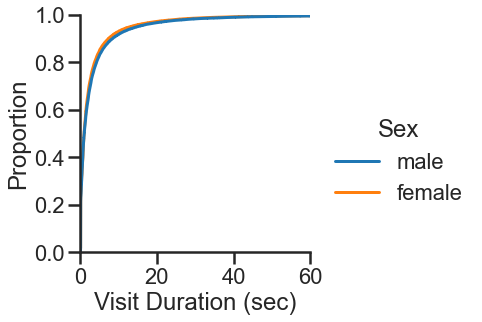

In [19]:
data_int = data_RFID_final
sns.displot(data=data_int, x="eventDuration", kind="ecdf", hue='Sex')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

<Figure size 720x360 with 0 Axes>

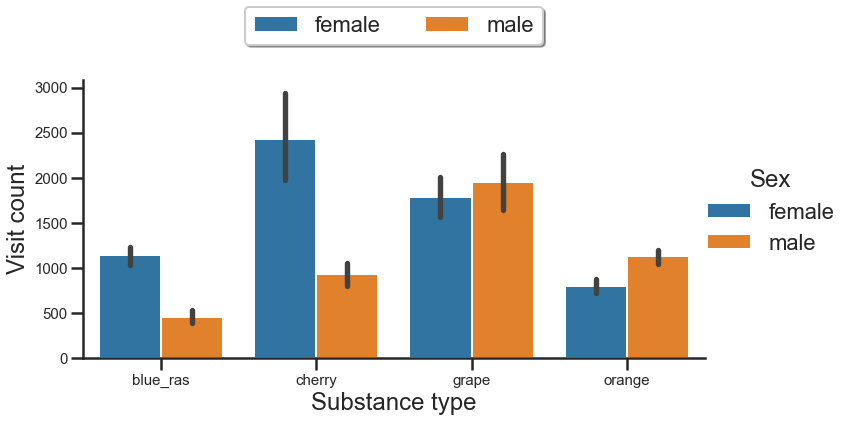

In [20]:
data_int = data_RFID_final

data_int = data_int.groupby(['Sex', 'IdRFID', 'day', 'unitLabel_drink'])['eventDuration'].sum().reset_index(name='count')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="unitLabel_drink", y='count', hue="Sex", kind='bar', height=5, aspect=2, ci=68,)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), 
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### VDM data

#### Make and clean df

In [21]:
#path for VDM file
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Manuscripts/2022_RFIDVDM/repo/c.br.o.g_fm_211213.csv'

#check where VDM data starts
data_VDM_int = pd.read_table(VDM_path, sep=';')
data_VDM_int = pd.DataFrame(data = data_VDM_int)
data_VDM_int.head(50)

,Columbus Instruments Device Interface Version 1.5
0,"Started On:,12/13/21 16:12:11"
1,[Experiment Setup Info]
2,"Program Path:,C:\Program Files (x86)\CI Multi-Device Interface"
3,"Data Path:,C:\Program Files (x86)\CI Multi-Device Interface\Data"
4,"Experiment File Name:,C:\Users\PhenoUser\Documents\VDM\final_setup\c.br.o.g_fm_211213.csv"
5,"Session Interval:,00:00:01"
6,"Experiment Duration:,0"
7,"Staggered Start Enable:,False"
8,[Channel Setup Info]
9,"Cage 1,Cage1"


In [22]:
row_drop = 22

data_VDM = pd.read_table(VDM_path, sep=';')
data_VDM = pd.DataFrame(data = data_VDM_int)

#will need to be updated in file doesn't start with 'Columbus Instruments....'
data_VDM = data_VDM.iloc[row_drop: , :]['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
data_VDM.columns = data_VDM.loc[row_drop].values
data_VDM = data_VDM.drop(row_drop)
    
data_VDM['VDM_file'] = VDM_path.split('/')[-1]

print(data_VDM.shape)
data_VDM.head()

(2976577, 13)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,VDM_file
23,0,1,12/13/21 16:12:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,c.br.o.g_fm_211213.csv
24,0,2,12/13/21 16:12:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,c.br.o.g_fm_211213.csv
25,0,3,12/13/21 16:12:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,c.br.o.g_fm_211213.csv
26,0,4,12/13/21 16:12:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,c.br.o.g_fm_211213.csv
27,0,5,12/13/21 16:12:16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,c.br.o.g_fm_211213.csv


In [23]:
data_VDM.columns

Index(['Int', 'Cage', 'Time', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', 'Drinking (ml)', 'Drinking Accum (ml)', '', 'VDM_file'], dtype='object')

#### Clean up column names

In [24]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 'drink_1_accum',
                    'drink_2', 'drink_2_accum',
                    'drink_3', 'drink_3_accum',
                    'drink_4', 'drink_4_accum',
                    'blank', 'VDM_file']

data_VDM = data_VDM[['VDM_file', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 
                    'drink_2', 
                    'drink_3', 
                    'drink_4', 
                    ]]

data_VDM.tail()

,VDM_file,Cage_VDM,VDM_Time,drink_1,drink_2,drink_3,drink_4
2976595,c.br.o.g_fm_211213.csv,4,12/20/21 12:47:20,0.000,0.000,0.000,0.000
2976596,c.br.o.g_fm_211213.csv,5,12/20/21 12:47:20,0.000,0.000,0.000,0.000
2976597,c.br.o.g_fm_211213.csv,6,12/20/21 12:47:20,0.000,0.000,0.000,0.000
2976598,c.br.o.g_fm_211213.csv,7,12/20/21 12:47:20,0.000,0.000,0.000,0.000
2976599,c.br.o.g_fm_211213.csv,8,12/20/21 12:47:20,0.000,0.000,0.000,0.000


#### Make into tidy df

In [25]:
#melt dataframe (new column of parameters)

meta_params = ['VDM_file', 'Cage_VDM', 'VDM_Time']
intake_params = ['drink_1', 'drink_2', 'drink_3', 'drink_4']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

data_VDM_tidy = data_VDM_tidy.replace({'':0.000})

data_VDM_tidy['value'] = data_VDM_tidy['value'].astype('float')

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(11906308, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
0,c.br.o.g_fm_211213.csv,1,12/13/21 16:12:16,drink_1,0.0
1,c.br.o.g_fm_211213.csv,2,12/13/21 16:12:16,drink_1,0.0
2,c.br.o.g_fm_211213.csv,3,12/13/21 16:12:16,drink_1,0.0
3,c.br.o.g_fm_211213.csv,4,12/13/21 16:12:16,drink_1,0.0
4,c.br.o.g_fm_211213.csv,5,12/13/21 16:12:16,drink_1,0.0


In [26]:
data_VDM_tidy['value'].unique()

array([0.   , 0.021, 0.042, 0.024, 0.126, 0.022, 0.063, 0.105, 0.084,
       0.048, 0.025, 0.05 , 0.044, 0.02 , 0.04 , 0.027, 0.054])

#### Drop times with no intake data

In [27]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0.000]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(18552, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
12023,c.br.o.g_fm_211213.csv,8,12/13/21 16:52:07,drink_1,0.021
57392,c.br.o.g_fm_211213.csv,1,12/13/21 19:22:37,drink_1,0.021
58919,c.br.o.g_fm_211213.csv,8,12/13/21 19:27:40,drink_1,0.021
72401,c.br.o.g_fm_211213.csv,2,12/13/21 20:12:24,drink_1,0.021
78447,c.br.o.g_fm_211213.csv,8,12/13/21 20:32:26,drink_1,0.021


#### Clean up datetime

In [28]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(18552, 13)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
12023,c.br.o.g_fm_211213.csv,8,12/13/21 16:52:07,drink_1,0.021,2021-12-13 16:52:07,1.639414e+09,2021-12-13,13,16:52:07,16,52,7
57392,c.br.o.g_fm_211213.csv,1,12/13/21 19:22:37,drink_1,0.021,2021-12-13 19:22:37,1.639423e+09,2021-12-13,13,19:22:37,19,22,37
58919,c.br.o.g_fm_211213.csv,8,12/13/21 19:27:40,drink_1,0.021,2021-12-13 19:27:40,1.639424e+09,2021-12-13,13,19:27:40,19,27,40
72401,c.br.o.g_fm_211213.csv,2,12/13/21 20:12:24,drink_1,0.021,2021-12-13 20:12:24,1.639426e+09,2021-12-13,13,20:12:24,20,12,24
78447,c.br.o.g_fm_211213.csv,8,12/13/21 20:32:26,drink_1,0.021,2021-12-13 20:32:26,1.639428e+09,2021-12-13,13,20:32:26,20,32,26


In [29]:
data_VDM_tidy_intake['VDM_day'].value_counts()

19    3069
17    2928
16    2923
18    2852
15    2724
14    2272
20    1406
13    378 
Name: VDM_day, dtype: int64

#### Add light dark and clean

In [30]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
12023,c.br.o.g_fm_211213.csv,8,12/13/21 16:52:07,drink_1,0.021,2021-12-13 16:52:07,1.639414e+09,2021-12-13,13,16:52:07,16,52,7,light
57392,c.br.o.g_fm_211213.csv,1,12/13/21 19:22:37,drink_1,0.021,2021-12-13 19:22:37,1.639423e+09,2021-12-13,13,19:22:37,19,22,37,dark_pm
58919,c.br.o.g_fm_211213.csv,8,12/13/21 19:27:40,drink_1,0.021,2021-12-13 19:27:40,1.639424e+09,2021-12-13,13,19:27:40,19,27,40,dark_pm
72401,c.br.o.g_fm_211213.csv,2,12/13/21 20:12:24,drink_1,0.021,2021-12-13 20:12:24,1.639426e+09,2021-12-13,13,20:12:24,20,12,24,dark_pm
78447,c.br.o.g_fm_211213.csv,8,12/13/21 20:32:26,drink_1,0.021,2021-12-13 20:32:26,1.639428e+09,2021-12-13,13,20:32:26,20,32,26,dark_pm


#### Map bottle contents

In [31]:
#note you will need to update this file with your VDM naming scheme (i.e., variable) and associated substances (i.e., VDM/substance pairs for each drinking station)
VDM_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Manuscripts/2022_RFIDVDM/repo/VDM_substance_mapping.xlsx'

VDM_bottle_assignment = pd.read_excel(VDM_bottle_assignment_path)
VDM_bottle_assignment = pd.DataFrame(data = VDM_bottle_assignment)
print(VDM_bottle_assignment.shape)
VDM_bottle_assignment.head(10)

(1, 6)


,cohort,VDM_file,drink_1,drink_2,drink_3,drink_4
0,flavor,c.br.o.g_fm_211213.csv,VDM_cherry,VDM_blueras,VDM_orange,VDM_grape


In [32]:
file=data_VDM_tidy_intake['VDM_file'].unique()[0]
VDM_bottle_map = VDM_bottle_assignment[VDM_bottle_assignment['VDM_file']==file].reset_index().loc[0,'drink_1':'drink_4'].to_dict()

data_VDM_tidy_intake['VDM_drink'] = data_VDM_tidy_intake['variable'].map(VDM_bottle_map)
print(data_VDM_tidy_intake.shape)

data_VDM_tidy_intake.head()

(18552, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
12023,c.br.o.g_fm_211213.csv,8,12/13/21 16:52:07,drink_1,0.021,2021-12-13 16:52:07,1.639414e+09,2021-12-13,13,16:52:07,16,52,7,light,VDM_cherry
57392,c.br.o.g_fm_211213.csv,1,12/13/21 19:22:37,drink_1,0.021,2021-12-13 19:22:37,1.639423e+09,2021-12-13,13,19:22:37,19,22,37,dark_pm,VDM_cherry
58919,c.br.o.g_fm_211213.csv,8,12/13/21 19:27:40,drink_1,0.021,2021-12-13 19:27:40,1.639424e+09,2021-12-13,13,19:27:40,19,27,40,dark_pm,VDM_cherry
72401,c.br.o.g_fm_211213.csv,2,12/13/21 20:12:24,drink_1,0.021,2021-12-13 20:12:24,1.639426e+09,2021-12-13,13,20:12:24,20,12,24,dark_pm,VDM_cherry
78447,c.br.o.g_fm_211213.csv,8,12/13/21 20:32:26,drink_1,0.021,2021-12-13 20:32:26,1.639428e+09,2021-12-13,13,20:32:26,20,32,26,dark_pm,VDM_cherry


In [33]:
#exclude boxes 1 and 4, RFID error
data_VDM_tidy_intake = data_VDM_tidy_intake[~((data_VDM_tidy_intake['Cage_VDM']=='1') | (data_VDM_tidy_intake['Cage_VDM']=='4'))]

In [34]:
data_VDM_tidy_intake['Cage_VDM'].value_counts()

2    3742
3    2592
6    2235
5    1964
8    1861
7    1664
Name: Cage_VDM, dtype: int64

<Figure size 720x360 with 0 Axes>

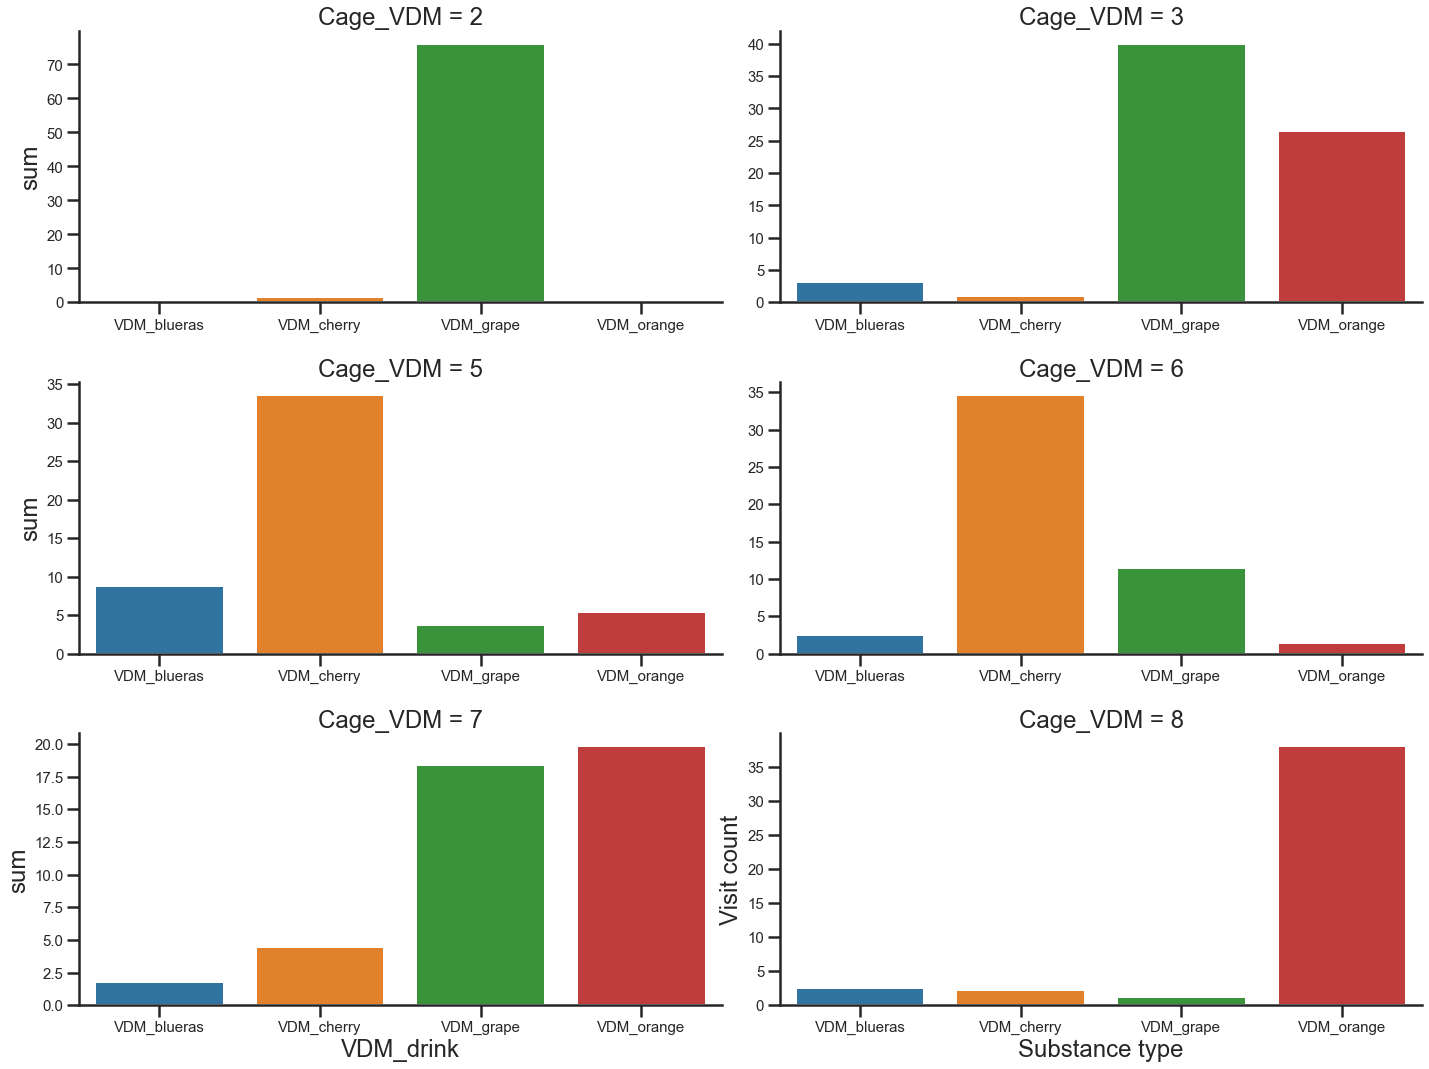

In [35]:
data_int = data_VDM_tidy_intake.groupby(['Cage_VDM', 'VDM_drink'])['value'].sum().reset_index(name='sum')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="VDM_drink", y='sum', kind='bar', height=5, aspect=2, 
            col='Cage_VDM', col_wrap=2, sharey=False, sharex=False)

plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### Filter RFID data by VDM times

In [36]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['VDM_drink', 'VDM_datetime']).reset_index(drop=True)

print(data_VDM_tidy_intake.groupby('Cage_VDM')['VDM_drink'].value_counts())
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

Cage_VDM  VDM_drink  
2         VDM_grape      3604
          VDM_cherry     81  
          VDM_orange     33  
          VDM_blueras    24  
3         VDM_grape      1429
          VDM_orange     1026
          VDM_blueras    95  
          VDM_cherry     42  
5         VDM_cherry     1327
          VDM_blueras    251 
          VDM_orange     217 
          VDM_grape      169 
6         VDM_cherry     1605
          VDM_grape      470 
          VDM_blueras    92  
          VDM_orange     68  
7         VDM_orange     883 
          VDM_grape      613 
          VDM_cherry     86  
          VDM_blueras    82  
8         VDM_orange     1571
          VDM_blueras    122 
          VDM_cherry     108 
          VDM_grape      60  
Name: VDM_drink, dtype: int64
(14058, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
0,c.br.o.g_fm_211213.csv,6,12/13/21 16:28:26,drink_2,0.021,2021-12-13 16:28:26,1.639413e+09,2021-12-13,13,16:28:26,16,28,26,light,VDM_blueras
1,c.br.o.g_fm_211213.csv,6,12/13/21 17:18:49,drink_2,0.021,2021-12-13 17:18:49,1.639416e+09,2021-12-13,13,17:18:49,17,18,49,light,VDM_blueras
2,c.br.o.g_fm_211213.csv,6,12/13/21 17:27:34,drink_2,0.021,2021-12-13 17:27:34,1.639416e+09,2021-12-13,13,17:27:34,17,27,34,light,VDM_blueras
3,c.br.o.g_fm_211213.csv,6,12/13/21 17:27:36,drink_2,0.021,2021-12-13 17:27:36,1.639416e+09,2021-12-13,13,17:27:36,17,27,36,light,VDM_blueras
4,c.br.o.g_fm_211213.csv,6,12/13/21 17:36:31,drink_2,0.042,2021-12-13 17:36:31,1.639417e+09,2021-12-13,13,17:36:31,17,36,31,light,VDM_blueras


In [37]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
print(data_RFID_final['unitLabel_drink'].value_counts())
data_RFID_final.head()

grape       63379
cherry      62113
blue_ras    41384
orange      39982
Name: unitLabel_drink, dtype: int64


,Round,Startdate,SIP_Cage,IdRFID,Animal,ARF_Cage,Sex,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,weight_pre,notes
0,flavor,21.12.13,7,041AC038C9,1619,468,male,blue_ras,Spyder2.26,0.075,light,1,1,16,17,2,2021-12-13 16:17:02.999011200,2021-12-13 16:17:03.074011200,16:17:02,16:17:03,977,58622,16,977,58562,Idspyder-21.12.13.csv,30.2,NaN
1,flavor,21.12.13,2,041ABFF18E,1615,467,male,blue_ras,Spyder1.6,5.002,light,1,1,16,18,45,2021-12-13 16:18:45.752976000,2021-12-13 16:18:50.754976000,16:18:45,16:18:50,978,58725,16,978,58665,Idspyder-21.12.13.csv,31.4,NaN
2,flavor,21.12.13,8,041ABFEC1B,1622,469,male,blue_ras,Spyder2.30,0.075,light,1,1,16,19,17,2021-12-13 16:19:17.218992000,2021-12-13 16:19:17.293992000,16:19:17,16:19:17,979,58757,16,979,58697,Idspyder-21.12.13.csv,34.8,NaN
3,flavor,21.12.13,7,041AC038C9,1619,468,male,blue_ras,Spyder2.26,2.008,light,1,1,16,19,45,2021-12-13 16:19:45.554995200,2021-12-13 16:19:47.562995200,16:19:45,16:19:47,979,58785,16,979,58725,Idspyder-21.12.13.csv,30.2,NaN
4,flavor,21.12.13,7,041AC00F03,1617,468,male,blue_ras,Spyder2.26,1.608,light,1,1,16,19,48,2021-12-13 16:19:48.289036800,2021-12-13 16:19:49.897036800,16:19:48,16:19:49,979,58788,16,979,58728,Idspyder-21.12.13.csv,32.5,NaN


In [38]:
data_comb = data_VDM_tidy_intake

VDM_RFID_mapping = {'VDM_cherry': 'cherry',
                    'VDM_orange': 'orange',
                    'VDM_blueras': 'blue_ras',
                    'VDM_grape': 'grape'}

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []

ld_cycle = []
ld_day = []


for index, row in data_comb.iterrows():
    if index%1000 == 0:
        print(index)
        
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = data_RFID_final[(data_RFID_final['SIP_Cage'] == int(row['Cage_VDM'])) & #match cage
                               (data_RFID_final['unitLabel_drink'] == VDM_RFID_mapping[row['VDM_drink']]) & #match tube
                               (data_RFID_final['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel_drink'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])

        ld_cycle.append(int_assign['ld_cycle'])
        ld_day.append(int_assign['ld_day'])
        
    except:
        print(index, 'pre', row['Cage_VDM'])
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)

        ld_cycle.append(np.nan)
        ld_day.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre

data_comb['ld_cycle'] = ld_cycle
data_comb['ld_day'] = ld_day


print(data_comb.shape)
data_comb.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
10370 pre 2
10372 pre 2
10380 pre 2
10443 pre 2
10509 pre 2
10665 pre 2
10711 pre 2
10890 pre 2
11000
11051 pre 2
11164 pre 2
11217 pre 2
11426 pre 2
11552 pre 2
11713 pre 2
11773 pre 2
11827 pre 2
11891 pre 2
12000
12104 pre 2
12314 pre 2
12537 pre 2
12652 pre 2
12717 pre 2
12907 pre 2
13000
13059 pre 2
13260 pre 2
13285 pre 2
13326 pre 2
13378 pre 2
13593 pre 2
13664 pre 2
13745 pre 2
13822 pre 2
14000
14004 pre 2
(14058, 22)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day
0,c.br.o.g_fm_211213.csv,6,12/13/21 16:28:26,drink_2,0.021,2021-12-13 16:28:26,1.639413e+09,2021-12-13,13,16:28:26,16,28,26,light,VDM_blueras,3.585,041AC028F2,blue_ras,2021-12-13 16:28:20.211024000,2021-12-13 16:28:23.796024000,light,1.0
1,c.br.o.g_fm_211213.csv,6,12/13/21 17:18:49,drink_2,0.021,2021-12-13 17:18:49,1.639416e+09,2021-12-13,13,17:18:49,17,18,49,light,VDM_blueras,0.075,041AC028F2,blue_ras,2021-12-13 17:13:38.625974400,2021-12-13 17:13:38.700974400,light,1.0
2,c.br.o.g_fm_211213.csv,6,12/13/21 17:27:34,drink_2,0.021,2021-12-13 17:27:34,1.639416e+09,2021-12-13,13,17:27:34,17,27,34,light,VDM_blueras,1.113,041AC006F3,blue_ras,2021-12-13 17:27:08.808969600,2021-12-13 17:27:09.921969600,light,1.0
3,c.br.o.g_fm_211213.csv,6,12/13/21 17:27:36,drink_2,0.021,2021-12-13 17:27:36,1.639416e+09,2021-12-13,13,17:27:36,17,27,36,light,VDM_blueras,1.113,041AC006F3,blue_ras,2021-12-13 17:27:08.808969600,2021-12-13 17:27:09.921969600,light,1.0
4,c.br.o.g_fm_211213.csv,6,12/13/21 17:36:31,drink_2,0.042,2021-12-13 17:36:31,1.639417e+09,2021-12-13,13,17:36:31,17,36,31,light,VDM_blueras,2.090,041AC033A1,blue_ras,2021-12-13 17:36:22.228963199,2021-12-13 17:36:24.318963199,light,1.0


In [39]:
data_comb.isna().sum()

VDM_file                   0 
Cage_VDM                   0 
VDM_Time                   0 
variable                   0 
value                      0 
VDM_datetime               0 
VDM_timestamp              0 
VDM_date                   0 
VDM_day                    0 
VDM_time                   0 
VDM_hour                   0 
VDM_min                    0 
VDM_second                 0 
ld_seg                     0 
VDM_drink                  0 
RFID_eventDuration         33
RFID_assign_id_pre         33
RFID_assign_var_pre        33
RFID_datetime_start_pre    33
RFID_datetime_end_pre      33
ld_cycle                   33
ld_day                     33
dtype: int64

### Compute VDM RFID timediff and filter (only keep data within 1 sec)

In [40]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb['VDM_RFID_timediff_bool'] = ['same' if x==0 else 'diff' for x in data_comb['VDM_RFID_timediff']]

data_comb.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,c.br.o.g_fm_211213.csv,6,12/13/21 16:28:26,drink_2,0.021,2021-12-13 16:28:26,1.639413e+09,2021-12-13,13,16:28:26,16,28,26,light,VDM_blueras,3.585,041AC028F2,blue_ras,2021-12-13 16:28:20.211024000,2021-12-13 16:28:23.796024000,light,1.0,2.203976,diff
1,c.br.o.g_fm_211213.csv,6,12/13/21 17:18:49,drink_2,0.021,2021-12-13 17:18:49,1.639416e+09,2021-12-13,13,17:18:49,17,18,49,light,VDM_blueras,0.075,041AC028F2,blue_ras,2021-12-13 17:13:38.625974400,2021-12-13 17:13:38.700974400,light,1.0,310.299025,diff
2,c.br.o.g_fm_211213.csv,6,12/13/21 17:27:34,drink_2,0.021,2021-12-13 17:27:34,1.639416e+09,2021-12-13,13,17:27:34,17,27,34,light,VDM_blueras,1.113,041AC006F3,blue_ras,2021-12-13 17:27:08.808969600,2021-12-13 17:27:09.921969600,light,1.0,24.078030,diff
3,c.br.o.g_fm_211213.csv,6,12/13/21 17:27:36,drink_2,0.021,2021-12-13 17:27:36,1.639416e+09,2021-12-13,13,17:27:36,17,27,36,light,VDM_blueras,1.113,041AC006F3,blue_ras,2021-12-13 17:27:08.808969600,2021-12-13 17:27:09.921969600,light,1.0,26.078030,diff
4,c.br.o.g_fm_211213.csv,6,12/13/21 17:36:31,drink_2,0.042,2021-12-13 17:36:31,1.639417e+09,2021-12-13,13,17:36:31,17,36,31,light,VDM_blueras,2.090,041AC033A1,blue_ras,2021-12-13 17:36:22.228963199,2021-12-13 17:36:24.318963199,light,1.0,6.681036,diff


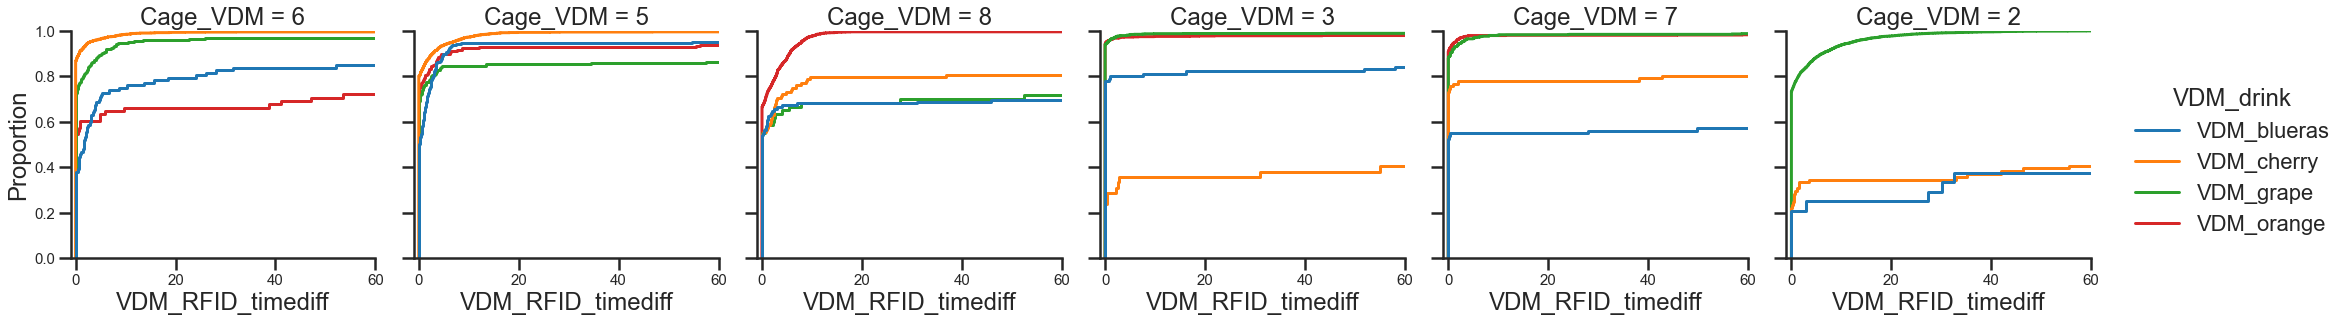

In [41]:
sns.displot(data=data_comb, x="VDM_RFID_timediff", kind="ecdf", hue='VDM_drink', col='Cage_VDM')

plt.xlim(-1, 60)
plt.show()

In [42]:
data_comb.groupby(['VDM_drink', 'Cage_VDM'])['VDM_RFID_timediff_bool'].value_counts()

VDM_drink    Cage_VDM  VDM_RFID_timediff_bool
VDM_blueras  2         diff                      19  
                       same                      5   
             3         same                      72  
                       diff                      23  
             5         diff                      128 
                       same                      123 
             6         diff                      60  
                       same                      32  
             7         same                      43  
                       diff                      39  
             8         same                      65  
                       diff                      57  
VDM_cherry   2         diff                      63  
                       same                      18  
             3         diff                      32  
                       same                      10  
             5         same                      1053
                       diff         

In [43]:
#only keep VDM data if within 1 second of RFID 
data_comb = data_comb[data_comb['VDM_RFID_timediff']<=1]

#### Add metadata

In [44]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(11585, 34)


,Round,Startdate,SIP_Cage,IdRFID,Animal,ARF_Cage,Sex,weight_pre,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,1528,c.br.o.g_fm_211213.csv,2,12/16/21 05:42:47,drink_1,0.021,2021-12-16 05:42:47,1.639633e+09,2021-12-16,16,05:42:47,5,42,47,dark_am,VDM_cherry,0.344,041ABFF5CF,cherry,2021-12-16 05:42:46.542038400,2021-12-16 05:42:46.886038400,dark,3.0,0.113961,diff
1,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,1862,c.br.o.g_fm_211213.csv,2,12/16/21 22:30:14,drink_1,0.021,2021-12-16 22:30:14,1.639694e+09,2021-12-16,16,22:30:14,22,30,14,dark_pm,VDM_cherry,0.715,041ABFF5CF,cherry,2021-12-16 22:30:13.362969600,2021-12-16 22:30:14.077969600,dark,4.0,0.000000,same
2,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,2478,c.br.o.g_fm_211213.csv,2,12/18/21 00:27:29,drink_1,0.021,2021-12-18 00:27:29,1.639787e+09,2021-12-18,18,00:27:29,0,27,29,dark_am,VDM_cherry,0.536,041ABFF5CF,cherry,2021-12-18 00:27:28.700006400,2021-12-18 00:27:29.236006400,dark,5.0,0.000000,same
3,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,2931,c.br.o.g_fm_211213.csv,2,12/18/21 20:39:05,drink_1,0.021,2021-12-18 20:39:05,1.639860e+09,2021-12-18,18,20:39:05,20,39,5,dark_pm,VDM_cherry,0.653,041ABFF5CF,cherry,2021-12-18 20:39:04.101004800,2021-12-18 20:39:04.754004800,dark,6.0,0.245995,diff
4,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,3934,c.br.o.g_fm_211213.csv,2,12/13/21 21:45:28,drink_4,0.021,2021-12-13 21:45:28,1.639432e+09,2021-12-13,13,21:45:28,21,45,28,dark_pm,VDM_grape,1.358,041ABFF5CF,grape,2021-12-13 21:45:26.933990400,2021-12-13 21:45:28.291990400,dark,1.0,0.000000,same


#### Add day, hour, and min counts

In [45]:
#column of running day count
dat_map = dict(zip(data_comb['VDM_date'].sort_values().unique(), np.arange(1,len(data_comb['VDM_date'].unique())+1)))
data_comb['day_count'] = data_comb['VDM_date'].map(dat_map)

#column of running min and second count within each day
data_comb['min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['sec_count'] = (data_comb['min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count across all days
data_comb['hour_count_running'] = (data_comb['day_count']*24) + data_comb['VDM_hour'] - 24
data_comb['min_count_running'] = (data_comb['hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['sec_count_running'] = (data_comb['min_count_running']*60) + data_comb['VDM_second'] - 60

print(data_comb.shape)
data_comb.head()

(11585, 40)


,Round,Startdate,SIP_Cage,IdRFID,Animal,ARF_Cage,Sex,weight_pre,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,1528,c.br.o.g_fm_211213.csv,2,12/16/21 05:42:47,drink_1,0.021,2021-12-16 05:42:47,1.639633e+09,2021-12-16,16,05:42:47,5,42,47,dark_am,VDM_cherry,0.344,041ABFF5CF,cherry,2021-12-16 05:42:46.542038400,2021-12-16 05:42:46.886038400,dark,3.0,0.113961,diff,4,342,20567,77,4662,279707
1,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,1862,c.br.o.g_fm_211213.csv,2,12/16/21 22:30:14,drink_1,0.021,2021-12-16 22:30:14,1.639694e+09,2021-12-16,16,22:30:14,22,30,14,dark_pm,VDM_cherry,0.715,041ABFF5CF,cherry,2021-12-16 22:30:13.362969600,2021-12-16 22:30:14.077969600,dark,4.0,0.000000,same,4,1350,81014,94,5670,340154
2,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,2478,c.br.o.g_fm_211213.csv,2,12/18/21 00:27:29,drink_1,0.021,2021-12-18 00:27:29,1.639787e+09,2021-12-18,18,00:27:29,0,27,29,dark_am,VDM_cherry,0.536,041ABFF5CF,cherry,2021-12-18 00:27:28.700006400,2021-12-18 00:27:29.236006400,dark,5.0,0.000000,same,6,27,1649,120,7227,433589
3,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,2931,c.br.o.g_fm_211213.csv,2,12/18/21 20:39:05,drink_1,0.021,2021-12-18 20:39:05,1.639860e+09,2021-12-18,18,20:39:05,20,39,5,dark_pm,VDM_cherry,0.653,041ABFF5CF,cherry,2021-12-18 20:39:04.101004800,2021-12-18 20:39:04.754004800,dark,6.0,0.245995,diff,6,1239,74345,140,8439,506285
4,flavor,21.12.13,2,041ABFF5CF,1616,467,male,29.5,NaN,3934,c.br.o.g_fm_211213.csv,2,12/13/21 21:45:28,drink_4,0.021,2021-12-13 21:45:28,1.639432e+09,2021-12-13,13,21:45:28,21,45,28,dark_pm,VDM_grape,1.358,041ABFF5CF,grape,2021-12-13 21:45:26.933990400,2021-12-13 21:45:28.291990400,dark,1.0,0.000000,same,1,1305,78328,21,1305,78268


In [46]:
data_comb['Substance'] = [x.split('_')[-1] for x in data_comb['VDM_drink']]

### Save files

In [47]:
#save data
data_VDM_tidy_intake.to_csv('211213_VDM_processed.csv')
data_RFID_final.to_csv('211213_RFID_processed.csv')
data_comb.to_csv('211213_processed.csv')